## EXPLORATORY DATA ANALYSIS
**GOAL**:
In this notebook we will explore our previously cleaned file containing data from NO2 levels in Madrid in the year 2018.

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [251]:
df = pd.read_parquet('clean_data.parquet')

## Understanding the Dataset

The dataset amalgamates information from various sources, as detailed in the `table_creation.ipynb` notebook. It encompasses hourly data on NO2 levels recorded at different stations in Madrid throughout the year 2018. Each row represents data from a specific hour and station.


### Variables Description

- **NO2_level:** This variable denotes the recorded levels of nitrogen dioxide (NO2) in the air. It serves as a key indicator of air quality.

- **FECHA:** Represents the timestamp of the data, providing information on the date and time of each recorded observation.

- **temp:** Indicates the temperature at the respective hour (recorded in Madrid).

- **area, name, address, altitude, type, longitude, latitude:** These features provide information about each station, including its geographical attributes and categorization.

# Exploratory Data Analysis Summary

1. **Correlations**:
   - Generate the correlation matrix.
   - Visualize crucial environmental correlations.

2. **Temporal Trends Visualizations**:
   - Illustrate temporal trends in pollution throughout the year.
   - Explore hourly, daily, and monthly variability in pollution levels.
   - Investigate differences during peak vs non-peak hours and weekdays vs weekends.


3. **Comparison Between Stations**:
   - Analyze yearly NO2 levels across stations to identify more affected areas.
   - Create heatmaps for a spatial visualization of NO2 levels.
   - Compare the monthly evolution of NO2 levels for selected stations.

### Future Steps:
4. **Analysis of Extraordinary Situations**:
   - Identify and analyze days with traffic restrictions or special events in Madrid.
   - Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.

In [252]:
df.head()

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude
0,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,635,UT,-3.712247,40.423853
1,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,635,UT,-3.712247,40.423853
2,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,635,UT,-3.712247,40.423853
3,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,635,UT,-3.712247,40.423853
4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,635,UT,-3.712247,40.423853


In [253]:
df.nunique()

NO2_level     296
FECHA        8759
temp          438
area            5
name           24
altitude       23
type            3
longitude      24
latitude       24
dtype: int64

1. **Correlations:**
   - Create the correlation matrix.
   - Visualize the most important environmental correlations.


In [254]:
numerical_cols = ['NO2_level', 'temp', 'altitude', 'longitude', 'latitude']

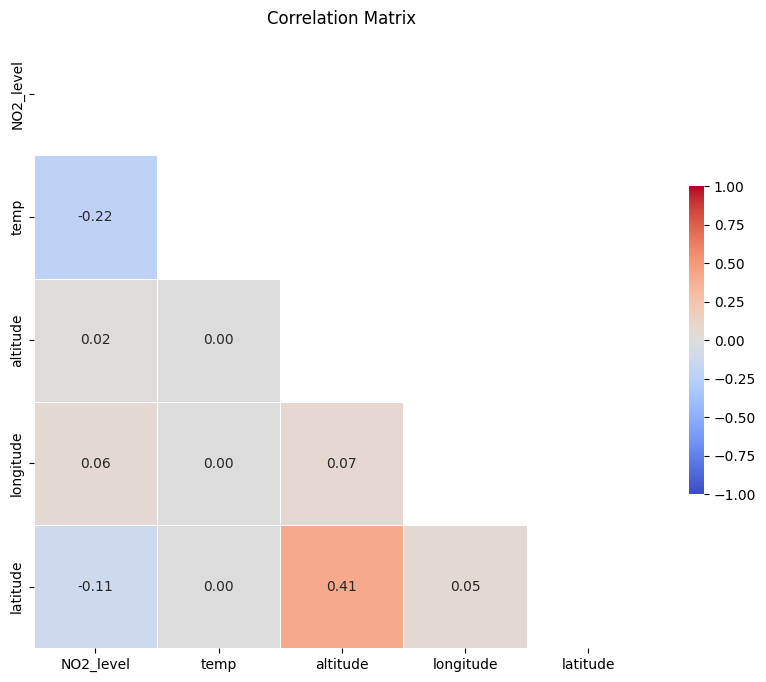

In [255]:
# Calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix')
plt.show()

We can ignore the correlations related to our stations. The most important insights are that temperature and latitude seem to have some (negative) correlation with NO2 levels

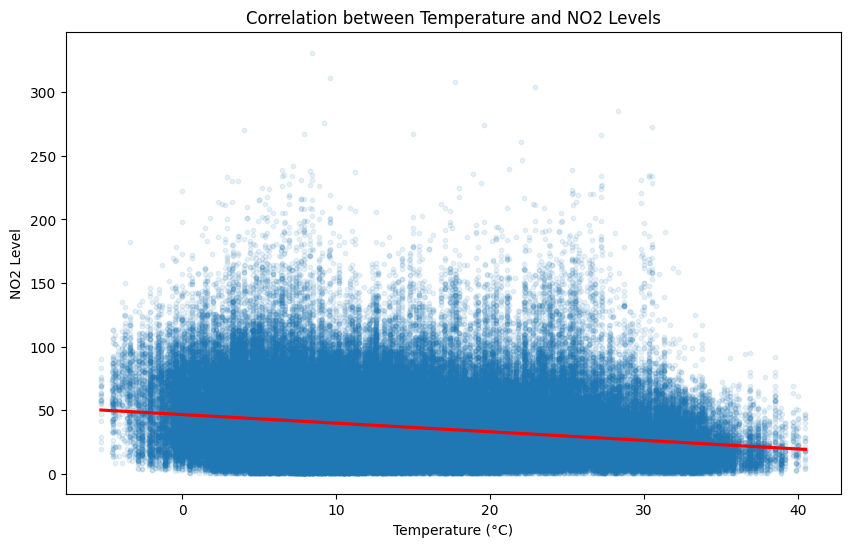

In [256]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='temp', y='NO2_level', data=df, scatter_kws={'s': 10, 'alpha': 0.1}, line_kws={'color': 'red'})
plt.title('Correlation between Temperature and NO2 Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('NO2 Level')
plt.show()

We can see some negative correlation between NO2 levels and temperature

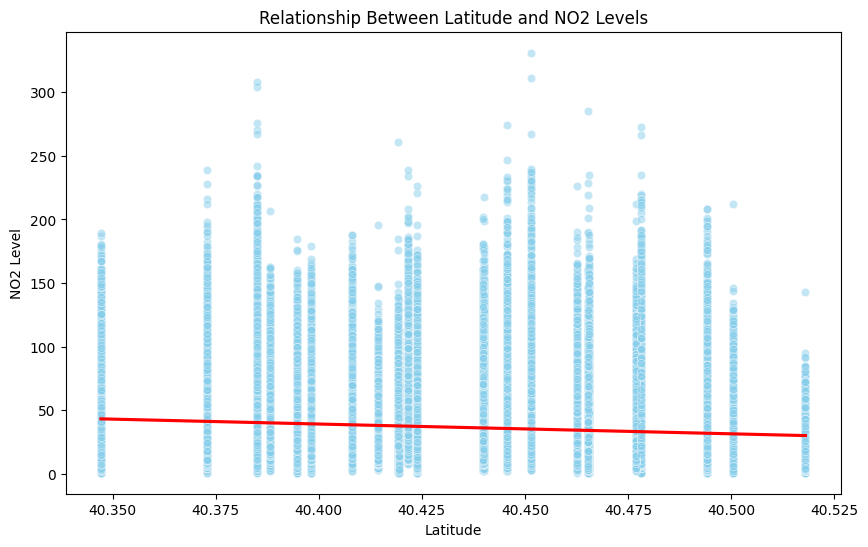

In [257]:
# Scatter plot to visualize the relationship between latitude and pollution levels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='NO2_level', data=df, color='skyblue', alpha=0.5)

# Corr line
sns.regplot(x='latitude', y='NO2_level', data=df, scatter=False, color='red')

plt.title('Relationship Between Latitude and NO2 Levels')
plt.xlabel('Latitude')
plt.ylabel('NO2 Level')
plt.show()

We can see a slight negative correlation between latitude and NO2 levels, but since our latitude depends on our 24 stations, we can't really make any insights.


2. **Temporal Trends Visualizations:**
   - Showcase temporal trends in pollution throughout the year.
   - Examine hourly, daily and monthly variability in pollution levels.


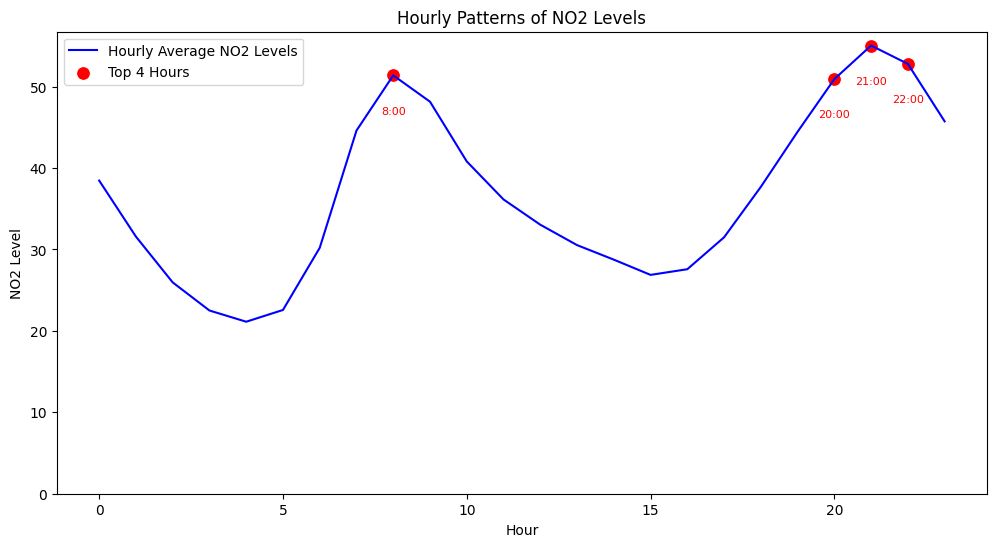

In [258]:
df['hour'] = df['FECHA'].dt.hour

# Plotting daily average NO2 levels
hourly_avg = df.groupby('hour')['NO2_level'].mean()
top_hours = hourly_avg.nlargest(4).index  # Identify top 4 hours

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg, label='Hourly Average NO2 Levels', color='blue')
sns.scatterplot(x=top_hours, y=hourly_avg[top_hours], color='red', s=100, label='Top 4 Hours')

# Annotate top hours
for hour in top_hours:
    plt.annotate(f'{hour}:00', xy=(hour, hourly_avg[hour]), xytext=(hour, hourly_avg[hour] - 5),
                 ha='center', va='bottom', color='red', fontsize=8)

plt.title('Hourly Patterns of NO2 Levels')
plt.xlabel('Hour')
plt.ylabel('NO2 Level')
plt.legend()
plt.ylim(0)  # Set y-axis to start at 0
plt.show()



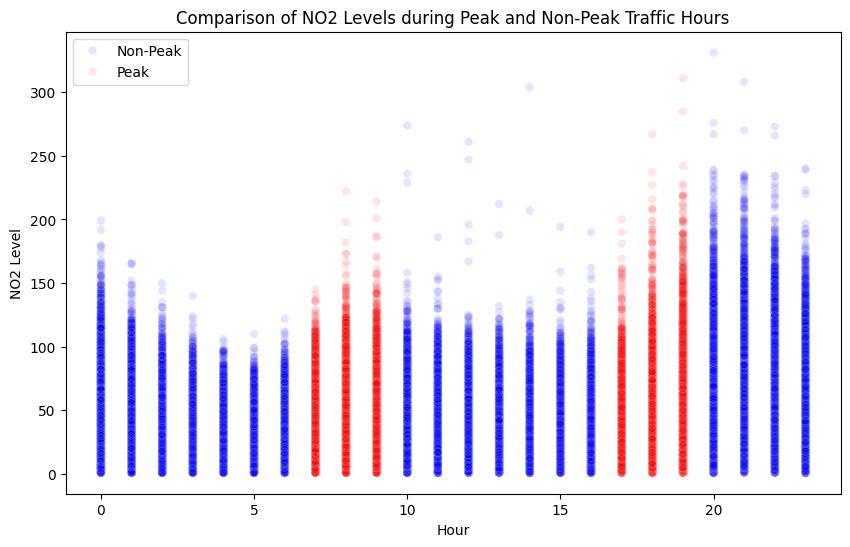

In [259]:
# Define peak and non-peak time ranges
peak_hours_morning = ((df['FECHA'].dt.hour >= 7) & (df['FECHA'].dt.hour <= 9))
peak_hours_evening = ((df['FECHA'].dt.hour >= 17) & (df['FECHA'].dt.hour <= 19))
non_peak_hours = ~peak_hours_morning & ~peak_hours_evening

# Create a new column to label peak and non-peak hours
df['Traffic_Time'] = 'Non-Peak'
df.loc[peak_hours_morning | peak_hours_evening, 'Traffic_Time'] = 'Peak'

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='NO2_level', hue='Traffic_Time', data=df, palette={'Non-Peak': 'blue', 'Peak': 'red'}, alpha=0.1)
plt.title('Comparison of NO2 Levels during Peak and Non-Peak Traffic Hours')
plt.xlabel('Hour')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()


We can see that during our peak traffic hours (7AM-9AM & 5PM-7PM), the pollution levels (NO2) rise

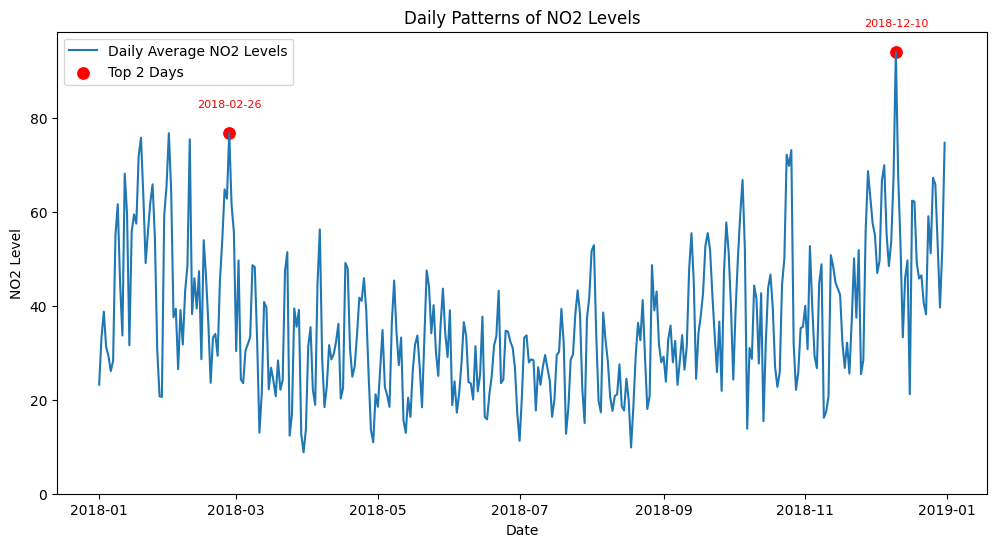

In [260]:
df['date'] = df['FECHA'].dt.date

# Plotting daily average NO2 levels
daily_avg = df.groupby('date')['NO2_level'].mean()
top_dates = daily_avg.nlargest(2).index  # Identify top 2 dates

plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_avg.index, y=daily_avg, label='Daily Average NO2 Levels')
sns.scatterplot(x=top_dates, y=daily_avg[top_dates], color='red', s=100, label='Top 2 Days')

# Annotate top dates
for date in top_dates:
    plt.annotate(f'{date}', xy=(date, daily_avg[date]), xytext=(date, daily_avg[date] + 5),
                 ha='center', va='bottom', color='red', fontsize=8)

plt.title('Daily Patterns of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.ylim(0)
plt.show()


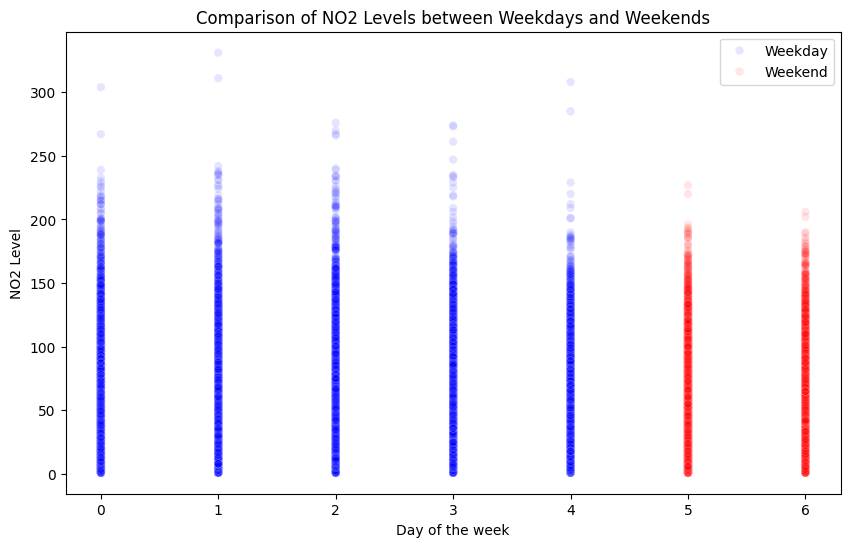

In [261]:
# Create a new column to label weekdays and weekends
df['Day_Type'] = df['FECHA'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x= df['FECHA'].dt.weekday, y='NO2_level', hue='Day_Type', data=df, palette={'Weekday': 'blue', 'Weekend': 'red'}, alpha=0.1)
plt.title('Comparison of NO2 Levels between Weekdays and Weekends')
plt.xlabel('Day of the week')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

In [262]:
# Create a new column for the day of the week
df['Day_of_Week'] = df['FECHA'].dt.day_name()

# Group by day of the week and calculate average NO2 level
avg_by_day = df.groupby('Day_of_Week')['NO2_level'].mean().reset_index()
avg_by_day.sort_values(by='NO2_level', ascending=False)

,Day_of_Week,NO2_level
4,Thursday,41.360987
6,Wednesday,41.019559
0,Friday,39.566431
5,Tuesday,39.357366
1,Monday,36.968789
2,Saturday,31.353094
3,Sunday,26.512705


We can see how pollution levels (NO2) are lower on weekends due to less traffic

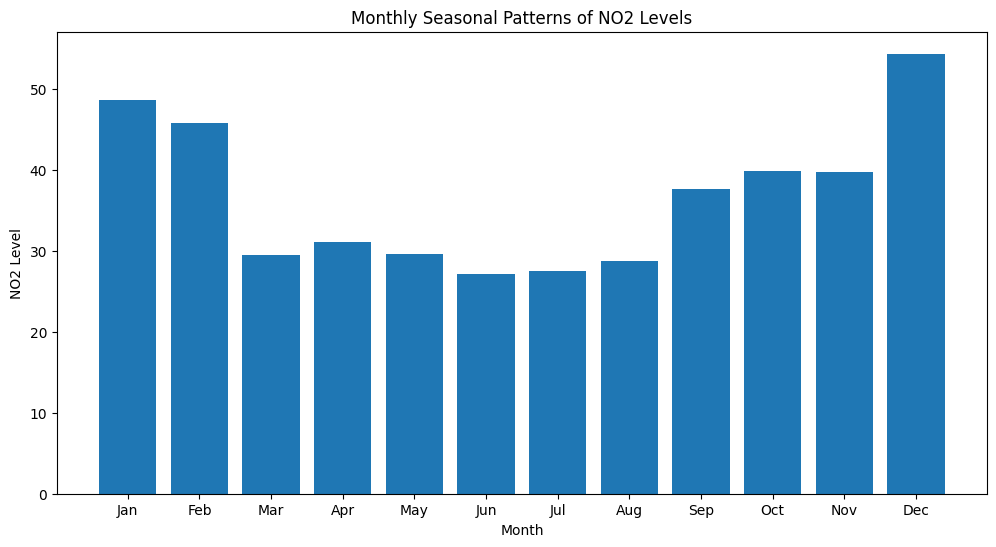

In [263]:
# Extract month information
df['month'] = df['FECHA'].dt.month

# Plotting monthly average NO2 levels
monthly_avg = df.groupby('month')['NO2_level'].mean()
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index, monthly_avg, tick_label=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Seasonal Patterns of NO2 Levels')
plt.xlabel('Month')
plt.ylabel('NO2 Level')
plt.show()

During the summer, the NO2 levels are at their lowest


3. **Comparison Between Stations:**
   - Compare NO2 levels between different stations to identify more affected areas.
   - Create heatmaps to visualize the NO2 levels by location
   - Compare monthly evolution of NO2 levels by stations


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


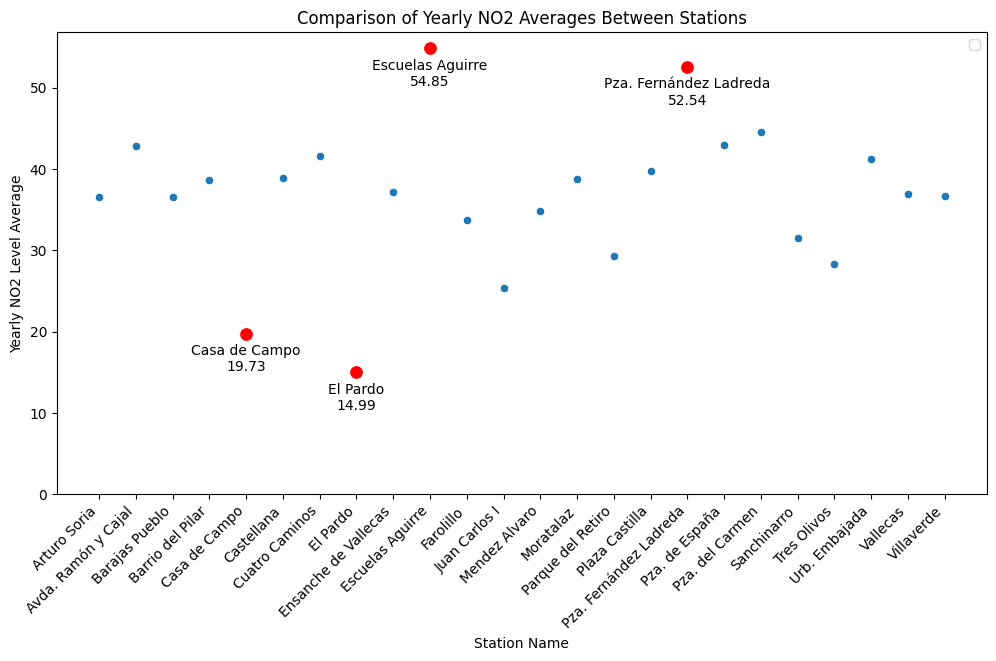

In [264]:
# Group by station and calculate the yearly average for NO2 levels
station_avg = df.groupby('name')['NO2_level'].mean().reset_index()

# Sort the stations by NO2 level
station_avg_sorted = station_avg.sort_values(by='NO2_level')

# Highlight the top 2 and bottom 2 stations
top_bottom_stations = pd.concat([station_avg_sorted.head(2), station_avg_sorted.tail(2)])

# Scatter plot to compare yearly averages between different stations
plt.figure(figsize=(12, 6))
sns.scatterplot(x='name', y='NO2_level', data=station_avg, alpha=1)
sns.scatterplot(x='name', y='NO2_level', data=top_bottom_stations, s=100, color='red', marker='o')

# Annotate the NO2 levels for top and bottom stations
for index, row in top_bottom_stations.iterrows():
    plt.annotate(f'{row["name"]}\n{row["NO2_level"]:.2f}', 
                 xy=(row['name'], row['NO2_level']), 
                 xytext=(0, -29),
                 textcoords='offset points',
                 ha='center', va='bottom')

plt.title('Comparison of Yearly NO2 Averages Between Stations')
plt.xlabel('Station Name')
plt.ylabel('Yearly NO2 Level Average')
plt.xticks(rotation=45, ha='right')  
plt.ylim(0) 
plt.legend()
plt.show()


We have significant differences in the average levels among stations. Let's visualize those differences by creating a heatmap

 **Heatmap:**
   - Let's create heatmaps (using Folium) to illustrate differences among stations in Madrid.

In [265]:
# Group by station and calculate the mean NO2 level
station_avg = df.groupby('name')['NO2_level'].mean().reset_index()

# Merge with the original DataFrame to get latitude and altitude
station_avg = station_avg.merge(df[['name', 'latitude', 'longitude', 'altitude']].drop_duplicates(), on='name', how='left')

In [266]:
# Create a map centered on Madrid
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Add data for latitude, longitude, and average NO2 level for each station
heat_data_avg = [[lat, lon, value] for lat, lon, value in zip(station_avg['latitude'], station_avg['longitude'], station_avg['NO2_level'])]

# Add the heatmap
HeatMap(heat_data_avg).add_to(m)

# Save the map as an HTML file
#m.save('heatmap_folium_avg.html')

In [267]:
m

As expected, the average (yearly) NO2 levels registered at El Pardo and Casa de Campo are the lowest (non urban zones), while Escuelas Aguirre (Salamanca) and Pza. Fernández Ladreda (Usera) have the highest levels

We could also explore creating dynamic maps to see the temporal evolution of NO2 levels over time

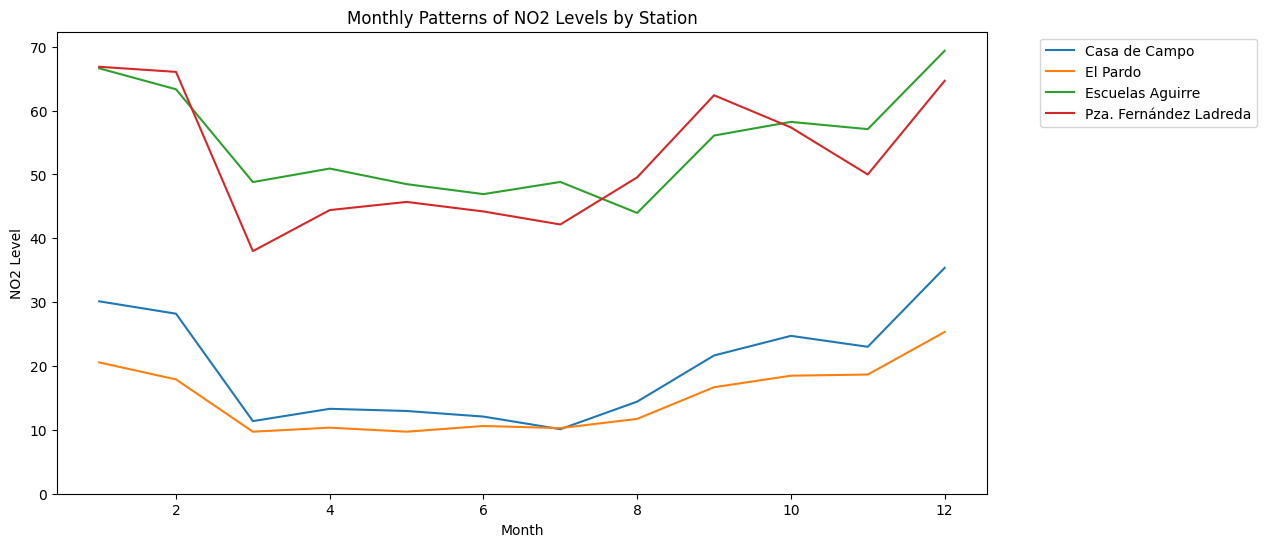

In [268]:
df['month'] = df['FECHA'].dt.month

selected_stations = ['El Pardo', 'Casa de Campo', 'Escuelas Aguirre', 'Pza. Fernández Ladreda']
filtered_df = df[df['name'].isin(selected_stations)]

# Plotting daily average NO2 levels
monthly_avg = filtered_df.groupby(['month', 'name'])['NO2_level'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='NO2_level', hue='name', data=monthly_avg)

plt.title('Monthly Patterns of NO2 Levels by Station')
plt.xlabel('Month')
plt.ylabel('NO2 Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0) 
plt.show()


### Future steps
4. **Analysis of Extraordinary Situations:**
   - Identify and analyze days with traffic restrictions or special events in Madrid. Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.